In [66]:
set.seed(888)
# libraries used by different members for the report
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(rvest)
library(stringr)
library(janitor)
library(lubridate)
library(GGally)
library(ISLR)

# libraries for visualization
library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)

# Title : Predicting  High-Value Players for the creation of a complex AI that can understand speech and react to complex environement using Minecraft 

# Introduction

**The Research Project**

The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC, led by Professor Frank Wood, is trying to build embodied AI agents that can behave like real human players inside Minecraft. Data was taken from players in a minecraft server called PLAICraft, and the players’ behaviours and traits were recorded. Currently, there are 196 observations of players, and in order to save resources, such as software licenses and server hardware, they need to recruit players who will play on the server for several hours.

**The Question**

We want to know if players' characteristics, like their experience, subscription to the game's newsletter, gender, and age, can predict how long in hours a player would play according to the dataset players?

**The Reasoning**

To better grasp human players' behaviors to build a believable AI, significant amounts of data are needed. This data is collected through interactions the players will have in the server. So it is crucial for the recruited participants to stay online for longer periods of time. The four characteristics of the players (experience, subscription to the game's newsletter, gender, and age) were chosen to be able to provide a comprehensive list of what should be prioritised when recruiting efforts. Since 3 of the variables (experience, gender, age) are self-identified, they may provide bias (social desirability in reporting gender, or overstatement of experience, etc). Only the data set players is needed for this question as it has all the information about the demographic. Sessions could be useful to see players' habits, but just to answer the question of most data collected, player habits would be too specific.


**The Dataset: Players**

There are 196 observations over rows for 7 variables in the columns of a tibble:

|**variable**|**data type**|**categories**|**meaning**|
|-|-|-|-|
| experience | character | 5 | skillset of the player: Beginner, Amateur, Regular, Veteran, Pro|
| subscribe | logical | 2 | indicating active subscription status: TRUE (subscribed) or FALSE (not subscribed) |
| hashedEmail | character | 196 | unique identifications |
| played_hours | real number | n/a | time in hours spent on the server by a player |
| name | character | 196 | unique identifications |
| gender | character | 7 | gender of the player : Male, Female, Non-binary, Agender, Two-Spirited, Prefer not to say, Other|
| age | real number | n/a | age of the player |


Potential Issues:
- Gender variable is inclusive but could reduce data accuracy since categories like "Prefer not to say" introduce ambiguity, as they could represent individuals from another gender group
- Positively skewed played_hours, the majority of values are very close to 0h with a few big outliers (around 200h)
- As mentioned, 3 (experience, gender, age) of the variables are self-identified; they may provide bias (social desirability in reporting age or gender, or overstatement of experience, etc).
- Emails and names are self-identified as well, but are not determining characteristics of players that affect play-time/engagement. They identify too specifically and don't represent a "type" of player

# Methods & Results:
To answer the question: Can experience, subscription to the game's newsletter, gender, and age predict how long in hours a player's total played hours will be? K-NN regression will be performed. The predictor variables will be experience, subscription to the game's newsletter, gender, and age, and the class/ label will be played hours. Since the class/label played hours is numerical, using K-NN regression would make sense since the aim is to produce numerical prediction values.

<h3> <u> Loading The Data: </u> </h3>

In [67]:
# Loading The Data 
players <- read_csv("https://raw.githubusercontent.com/ctrl-tiramisu/dsci100-group-008/refs/heads/main/players.csv", show_col_types = FALSE)
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


<h3> <u> Summary Statistics of The Data Set </u> </h3>

The table below shows the summary statistics of the players' played hours in our data set. It can be seen that the range of played hours is quite large, with the minimum being 0 (meaning under 1 hour) and the maximum being 223 hours. This entails that there may be outliers in our data set.

In [68]:
# a summary of the data set relevant for EDA related to the planned analysis

players_relevent_summary <- players |>
  summarise(
    variable = "played_hours",
    mean = mean(played_hours, na.rm = TRUE),
    median = median(played_hours, na.rm = TRUE),
    standard_deviation = sd(played_hours, na.rm = TRUE),
    minimum = min(played_hours, na.rm = TRUE),
    maximum = max(played_hours, na.rm = TRUE))


players_relevent_summary

variable,mean,median,standard_deviation,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
played_hours,5.845918,0.1,28.35734,0,223.1


<h3> <u> Wrangling and Cleaning The Data </u> </h3>

Generally, the players data set is already tidy with each row having a single observation, each column a single variable, and each value being in a single cell. However, to go a further step into making sure the analysis goes through smoothly, the following code is shown below. In addition, it was discussed earlier that the huge range in our data may be a sign of outliers.
After calculating the upper fence and the lower fence in our data, it was found that hours above 50 are outliers in the data. They are removed from the data because KNN can be sensitive to outliers, as they may affect distance calculations.

In [69]:
players_tidy <- players|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.logical(subscribe),
        experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")), #levels to ensure R does not order alphabeticall but with progressiong
        gender = factor(gender))|>
    filter(played_hours <50)

head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Furthermore, since the gender variable contains 7 categories, where some of the categories have way too little data. Having too many categories and some of them having way too little data may affect the analysis negatively. To resolve this issue, we combine the genders that have too little data into the "Other" category. Leaving three overall categories under the gender variable- Male, Female, and Other.

In [70]:
## Encode gender variable to Male, Female, and Other
players_tidy <- players_tidy |> mutate(
    gender = case_when(
      gender %in% c("Male") ~ "Male",
      gender %in% c("Female") ~ "Female",
      TRUE ~ "Other"),
    gender = as.factor(gender))
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Moreover, since KNN relies on distance calculations and requires numerical data, the values of the categorical variables being used for the analysis (experience, gender, and subscribe) are converted into "dummy" numerical values representing each of the categories under our categorical variables:

In [71]:
#Made Categorical Variables into Numerical
players_number <- players_tidy |> 
mutate(gender = case_when(
      gender %in% c("Male") ~ 1,
      gender %in% c("Female") ~ 2,
      TRUE ~ 3))|>

mutate(experience = case_when(
      experience %in% c("Beginner") ~ 1,
      experience %in% c("Amateur") ~ 2,
      experience %in% c("Regular") ~ 3,
      experience %in% c("Pro") ~ 4,
      experience %in% c("Veteran") ~ 5))|>

mutate(subscribe = case_when(
      subscribe %in% c("TRUE") ~ 1,
      subscribe %in% c("FALSE") ~ 0))


players_number <- players_number|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.numeric(subscribe),
        experience = as.numeric(experience),
        gender = as.numeric(gender))
head(players_number)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
4,1,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,1,9
5,1,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,1,17
5,0,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,1,17
2,1,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,2,21
3,1,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,1,21
2,1,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,2,17


Next, the NA values in the data that are not useful must be dealt with. Since the players' data set only has two NA values under the Age variable, removing them will suffice. 

In [72]:
## Select for only predictors and target variables
players_selected <- select(players_number, Age, experience, subscribe, gender, played_hours)|>
    drop_na() 
head(players_selected)

Age,experience,subscribe,gender,played_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,4,1,1,30.3
17,5,1,1,3.8
17,5,0,1,0.0
21,2,1,2,0.7
21,3,1,1,0.1
17,2,1,2,0.0


<h3> <u> Visualizations for The Data Set </u> </h3>

In [73]:
# visualizations of the dataset that is relevant for exploratory data analysis related to the planned analysis

options(repr.plot.width = 16, repr.plot.height = 6)

# Distribution of Total Played Hours

player_distribution_w_outliers <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30, fill = "pink", color = "black", alpha = 0.8) +
    labs(title = "Figure 1 (A): Distribution of Total Played Hours (w/ Outliers)",x = "Played Hours",y = "Number of Players") +
  theme_minimal(base_size = 12) +
  geom_vline(aes(xintercept = mean(played_hours)), 
             color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 150, y = 65, label = "Mean = 6.52", color = "red", size = 4)

player_distribution_no_outliers <- players_tidy |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30, fill = "pink", color = "black", alpha = 0.8) +
    labs(title = "Figure 1 (B): Distribution of Total Played Hours (Removed Outliers)",x = "Played Hours",y = "Number of Players") +
  theme_minimal(base_size = 12) +
  geom_vline(aes(xintercept = mean(played_hours)), 
             color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 150, y = 65, label = "Mean = 6.52", color = "red", size = 4)



# Played Hours by Player Experience Level
players_experience_hours1 <- players |>
  ggplot(aes(x = experience, y = played_hours)) +
  geom_point() +
  labs(title = "Figure 2 (A) : Played Hours by Player Experience Level (w/ Outliers)", x = "Experience Level", y = "Total Played Hours") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

players_experience_hours2 <- players_tidy |>
  ggplot(aes(x = experience, y = played_hours)) +
  geom_point() +
  labs(title = "Figure 2 (B) : Played Hours by Player Experience Level (Removed Outliers)", x = "Experience Level", y = "Total Played Hours") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Played Hours by Newsletter Subscription


players_subscribe_hours1 <- players_tidy |>
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_point(alpha = 0.8,) +
  labs(title = "Figure 3 : Played Hours by Newsletter Subscription (Removed Outliers)", x = "Subscribed to Newsletter", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

# Played Hours vs. Age
players_age_played1 <- players |>
  ggplot(aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 4 (A) : Played Hours vs. Age (w/ Outliers)", x = "Age (years)", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

players_age_played2 <- players_tidy |>
  ggplot(aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 4: Played Hours vs. Age (Removed Outliers)", x = "Age (years)", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

# Average Played Hours by Gender

players_gender <- players|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.logical(subscribe),
        experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")), #levels to ensure R does not order alphabeticall but with progressiong
        gender = factor(gender))|>
    filter(played_hours <50)

gender_played1 <- players |>
  group_by(gender) |>
  summarise(mean_hours = mean(played_hours)) |>
  ggplot(aes(x = gender, y = mean_hours)) +
  geom_bar(stat = "identity", fill = "orange", color = "black") +
  labs(title = "Figure 5 (A) : Average Played Hours by Gender (w/ Outliers)", x = "Gender", y = "Average Played Hours") +
  theme_minimal(base_size = 12) 

gender_played2 <- players_gender |>
  group_by(gender) |>
  summarise(mean_hours = mean(played_hours)) |>
  ggplot(aes(x = gender, y = mean_hours)) +
  geom_bar(stat = "identity", fill = "orange", color = "black") +
  labs(title = "Figure 5 (B): Average Played Hours by Gender (Removed Outliers)", x = "Gender", y = "Average Played Hours") +
  theme_minimal(base_size = 12) 

# proportions across gender
num_gender <- players_tidy |>
    group_by(gender) |>
    summarise(numgender = n(), mean_hrs = (mean(played_hours)), tot_hrs= (sum(played_hours)))

# proportions across experience
skillset_counts <- players_tidy |>
  group_by(experience) |>
  summarise(n_players = n()) |>
  mutate(percentage = round(100 * n_players / sum(n_players), 1))|>
  ungroup()

experience_proportion <- players_tidy |> 
    group_by(experience) |>
    summarise(num_players = n(), mean_hours_experience = mean(played_hours), total_hrs = sum(played_hours))

Figure 1 (A) below shows that most of the players' played hours are below 25. In fact, most are in the 0-hour play time (meaning they have a total played hours below 1 hour). There are very few players who have a high number of played hours. Figure 1 (B), with the outliers removed, is shown below for reference.

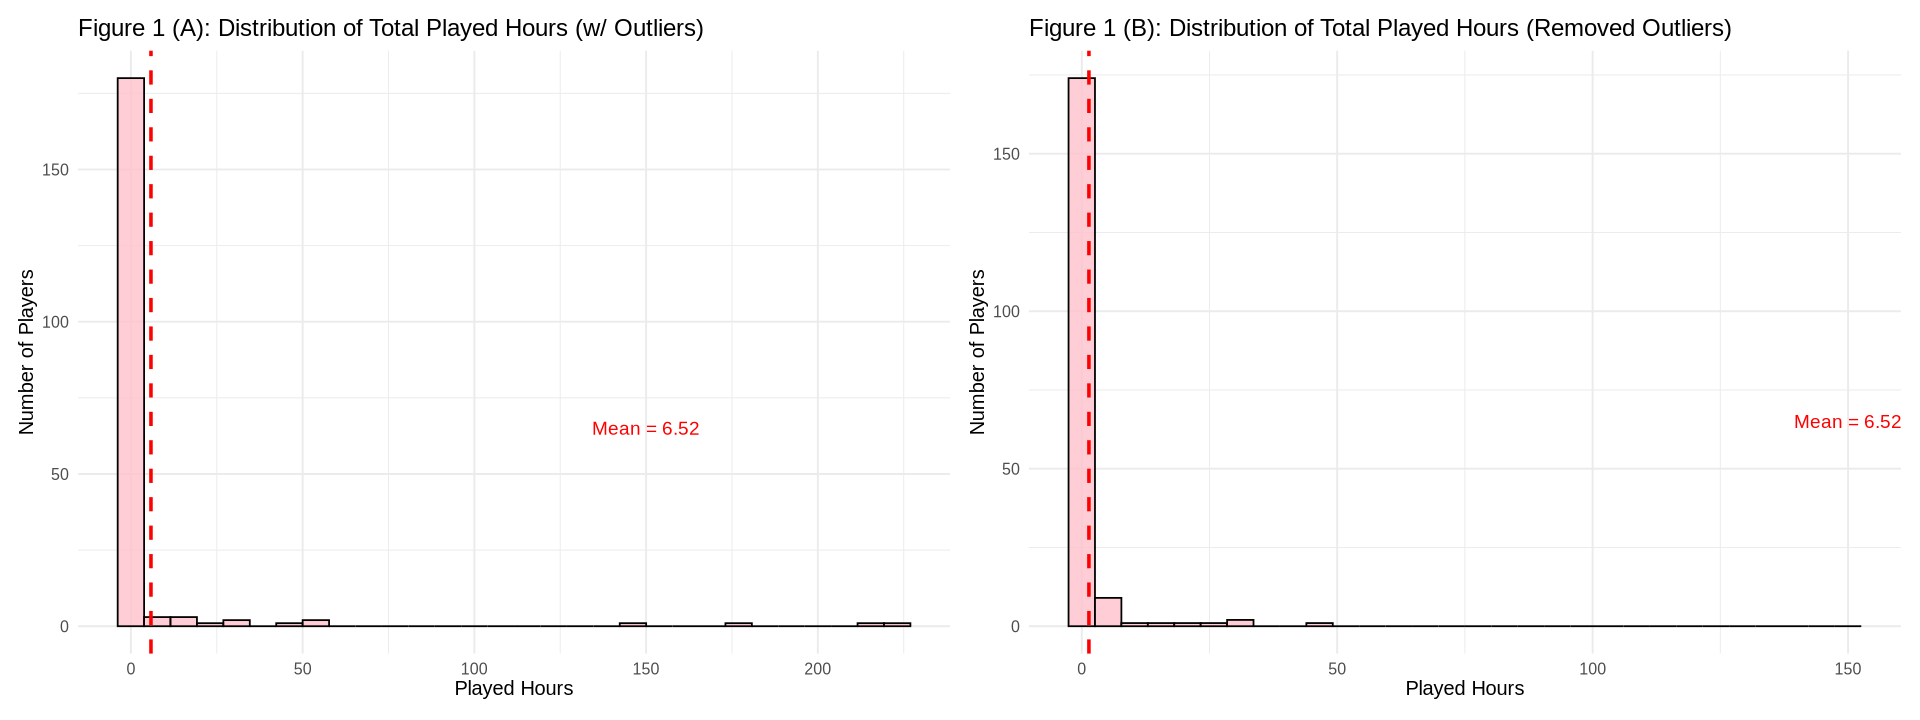

In [74]:
(player_distribution_w_outliers + player_distribution_no_outliers)

Figure 2 (A) shows that with outliers most of the experience levels have played hours around <50 hours. There are, however, players with an unusually high amount of total played hours in Amateur and Regular experience levels. Therefore, we have to remove the outliers as presented in Figure 2 (B). Here, it can be observed that Amateur and Pro players include players with the largest amount of total hours played.

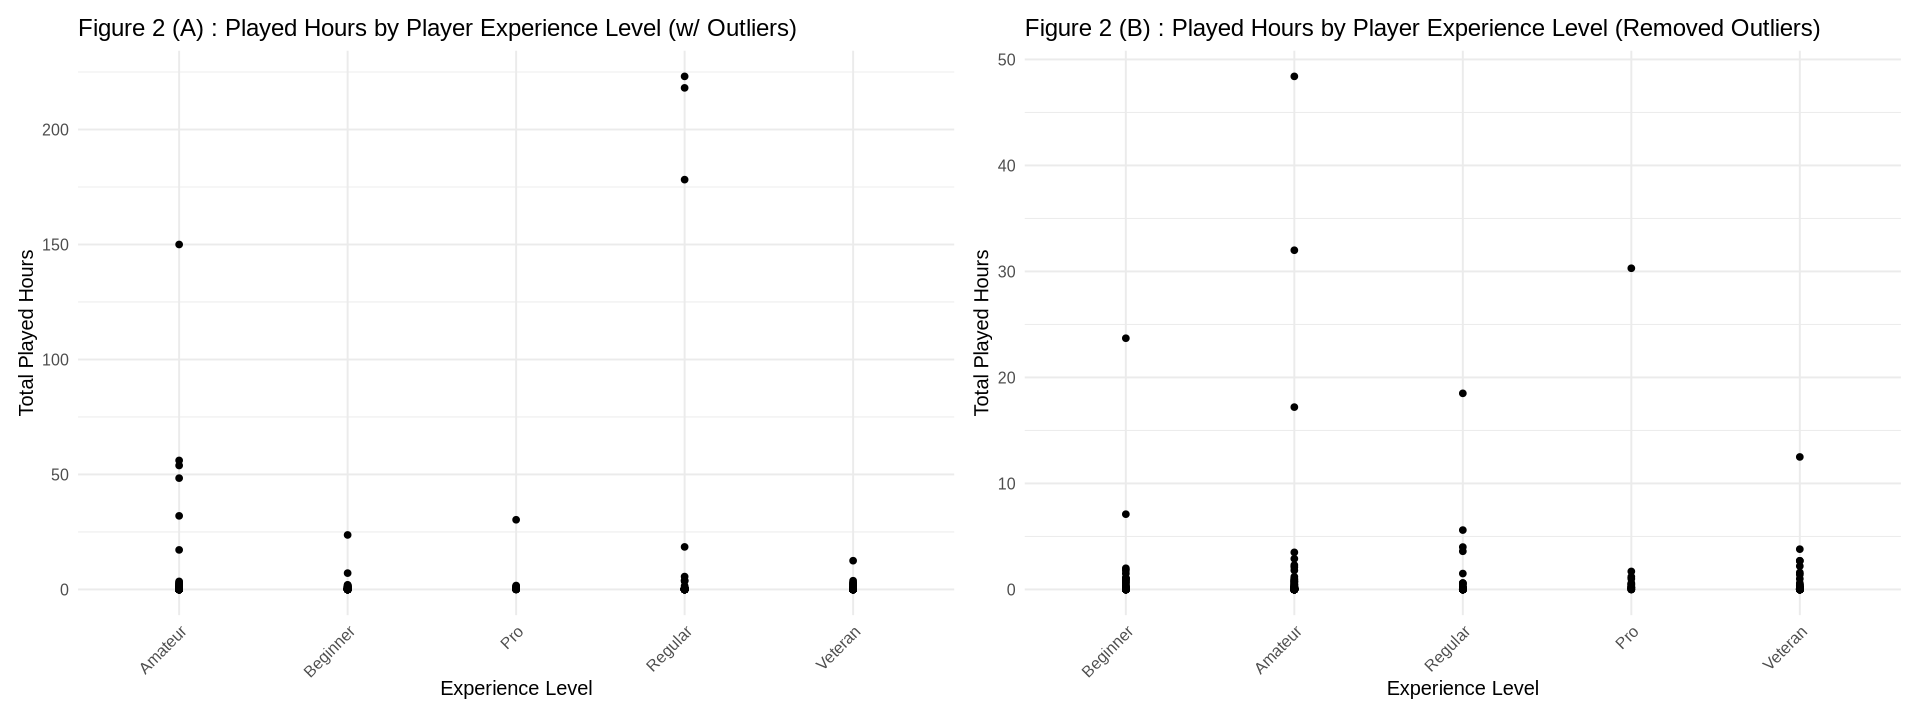

In [75]:
(players_experience_hours1 + players_experience_hours2)

Figure 3 shows that most players are subscribed to the game's newsletter. Subscribers dominate across all played-hour ranges, while non-subscribers appear mostly among players with hours less than 10. 

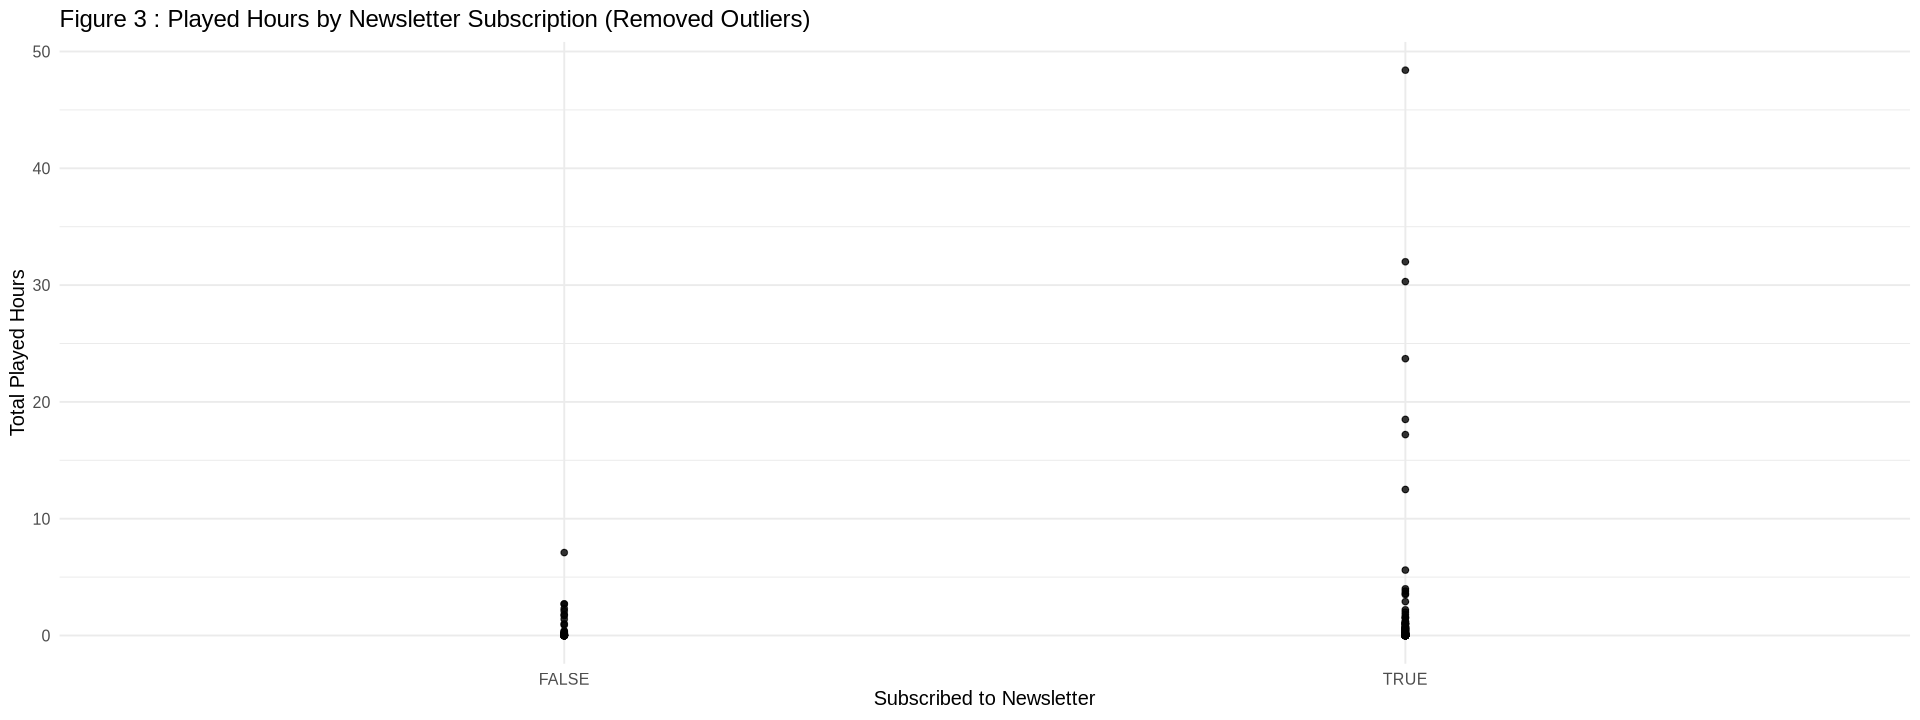

In [76]:
(players_subscribe_hours1)

Figure 4 displays the relationship between players’ ages and their total played hours after removing outliers. The plot shows that most players fall between 10 and 30 years old, and this age range contains the greatest variation in played hours, including the highest observed values. Younger players appear more likely to have higher playtime, with several individuals in their late teens and early twenties showing substantially elevated hours. In contrast, older players are less common in the dataset and tend to have consistently lower played hours. Overall, the figure suggests that heavy gameplay is concentrated among younger users, while older players generally spend less time playing.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


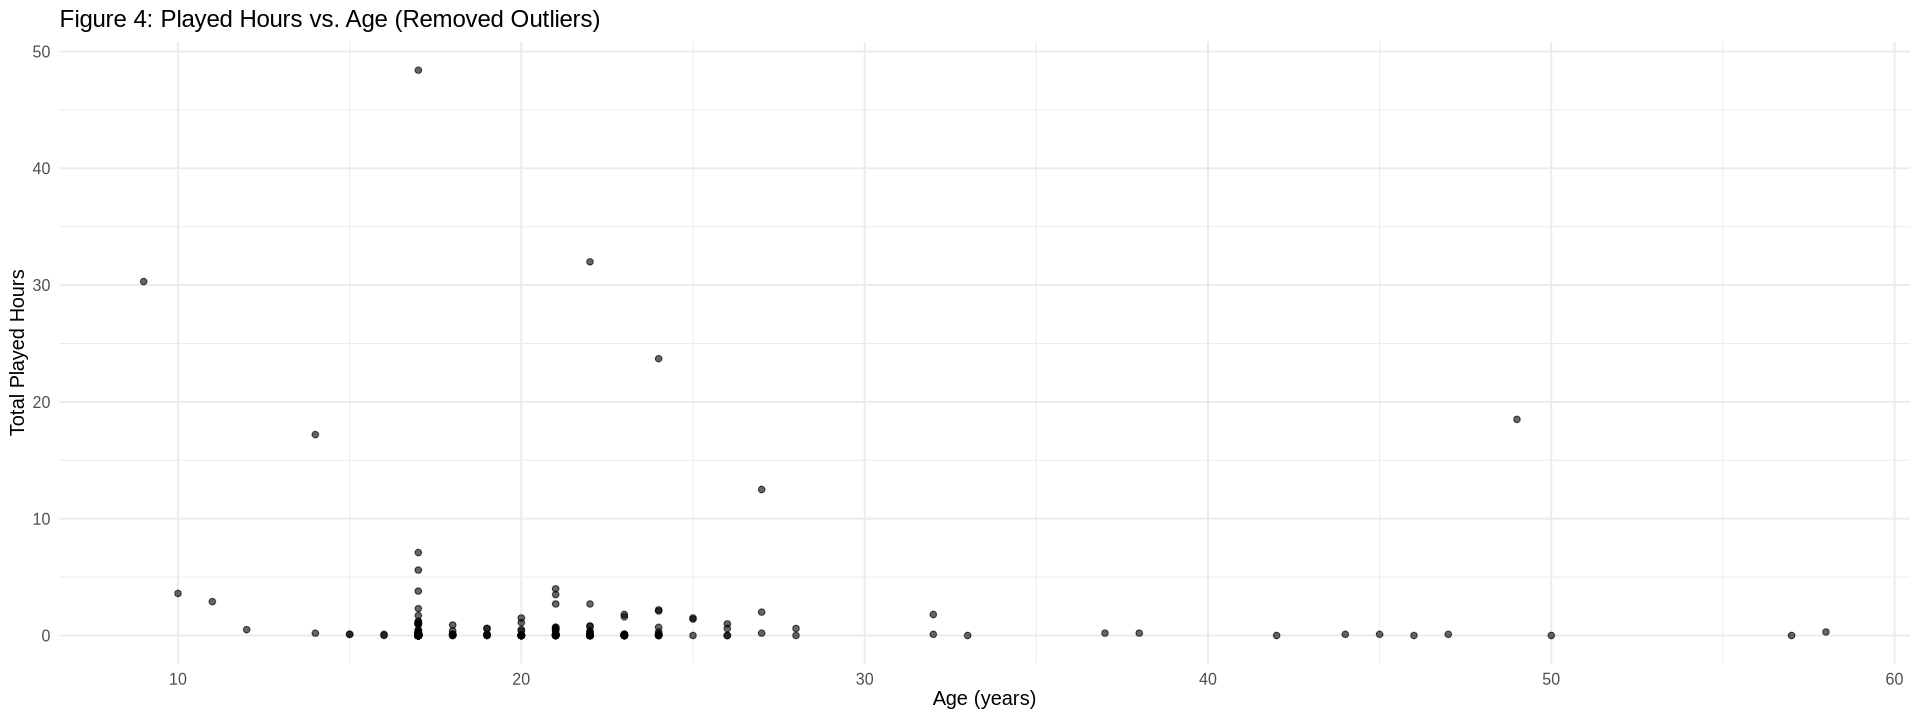

In [77]:
players_age_played2

In Figure 5(A), which includes all observations, the average played hours vary widely across gender groups because several extreme values heavily influence the means. In particular, the Non-binary group shows the highest average played hours, but this is driven by a few very large outliers in a small group. After removing outliers in Figure 5(B), the pattern changes substantially, the Non-binary group’s average drops sharply, revealing that their high value in the first plot was not representative of typical gameplay. Instead, the Agender group now has the highest average played hours, while Female and Male players show more moderate and similar values. The smaller categories: Other, Prefer not to say, and Two-Spirited remain low in both plots. Overall, comparing the two figures shows how outliers and small group sizes can distort averages, and how removing extreme values gives a clearer picture of typical gameplay behavior across genders.

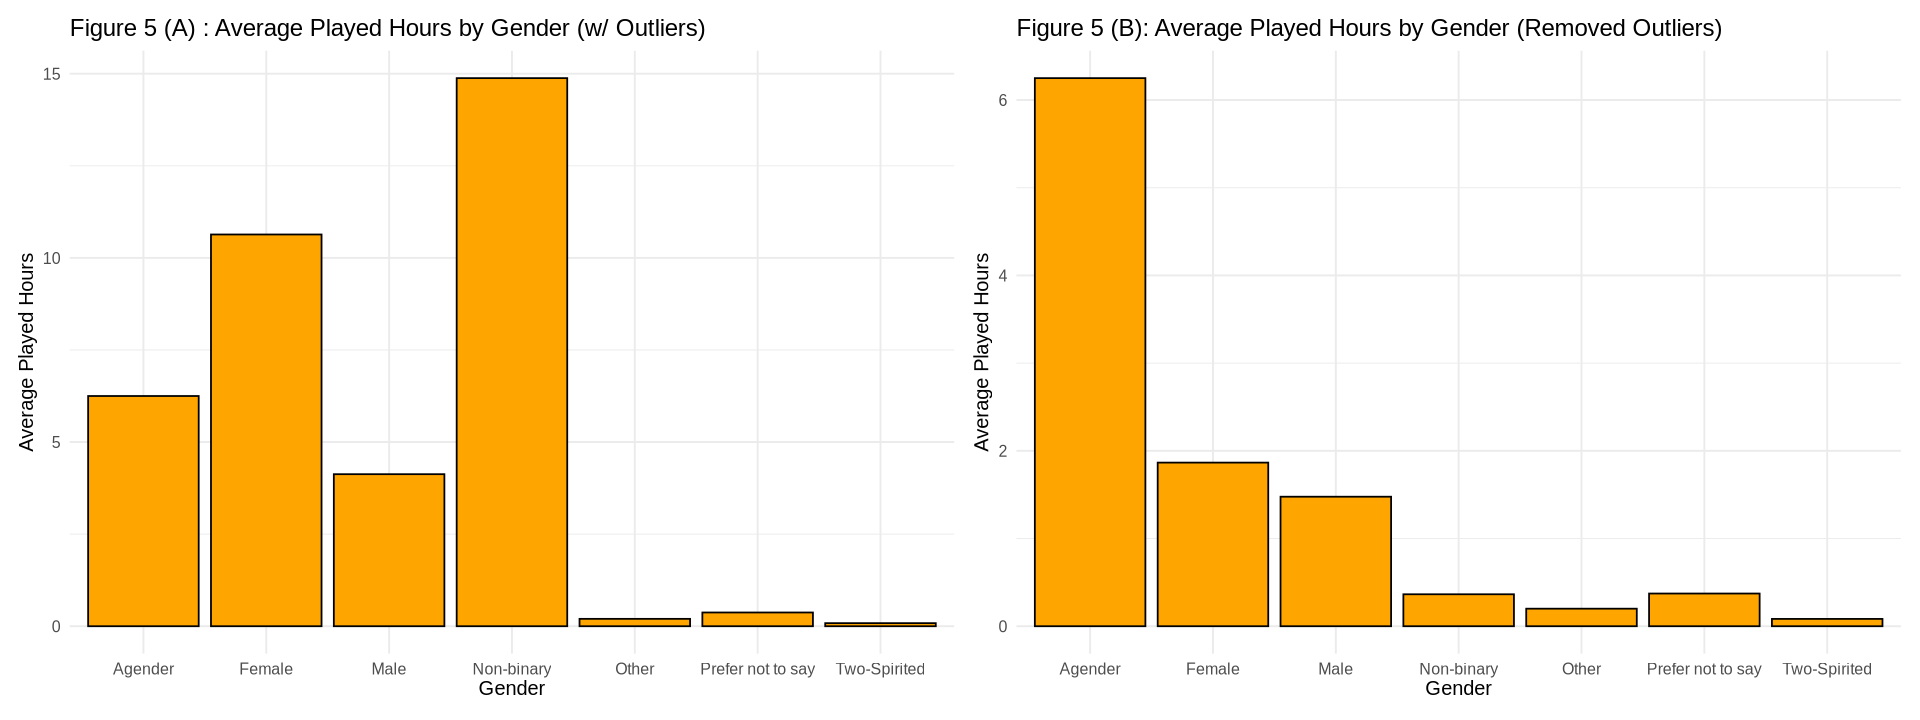

In [78]:
(gender_played1 + gender_played2)

<h1> DESCRIBE THE PROPORTIONS- JOHNNY: </h1>

!!DESCRIBE HERE the table below

In [79]:
num_gender

gender,numgender,mean_hrs,tot_hrs
<fct>,<int>,<dbl>,<dbl>
Female,35,1.8657143,65.3
Male,121,1.4768595,178.7
Other,34,0.6588235,22.4


!! DESCRIBE HERE the table below

In [80]:
skillset_counts

experience,n_players,percentage
<fct>,<int>,<dbl>
Beginner,35,18.4
Amateur,60,31.6
Regular,33,17.4
Pro,14,7.4
Veteran,48,25.3


!! DESCRIBE HERE the table below

In [81]:
proportion

experience,num_players,mean_hours_experience,total_hrs
<fct>,<int>,<dbl>,<dbl>
Beginner,35,1.2485714,43.7
Amateur,60,1.9850000,119.1
Regular,33,1.0939394,36.1
Pro,14,2.6000000,36.4
Veteran,48,0.6479167,31.1


<h3> <u> The Data Analysis  </u> </h3>

The following stages are where the K-NN regression analysis will begin. The first step is to split the data into a training set (0.70) and a testing set (0.30). The training set will be used below to find the optimal k-value.

In [82]:
## Split the data 70/30
players_split <- initial_split(players_selected, prop = 0.70, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

In the code below, the model is tuned in order to find an optimal k-value that can be used for the K-NN regression model. 

In [83]:

## Find Best k value for KNN Regression

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_recipe <- recipe(played_hours ~ ., data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 


## 5 Fold Validation
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)
gridvals <- tibble(neighbors = seq(from = 1, to = 16, by = 1))

players_workflow <-  workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec)

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_min <- players_results |>
  filter(mean == min(mean))

players_min

k_min <- players_min$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,rmse,standard,5.362912,5,1.216429,Preprocessor1_Model16


After finding the optimal k-value above, this will now be used to predict the played hours in the test data using the variables in the training data. The Figure 6 plot below shows the plot of the tested k values and their RMSEs. From the plot below, we can see which k value produces the lowest RMSE.

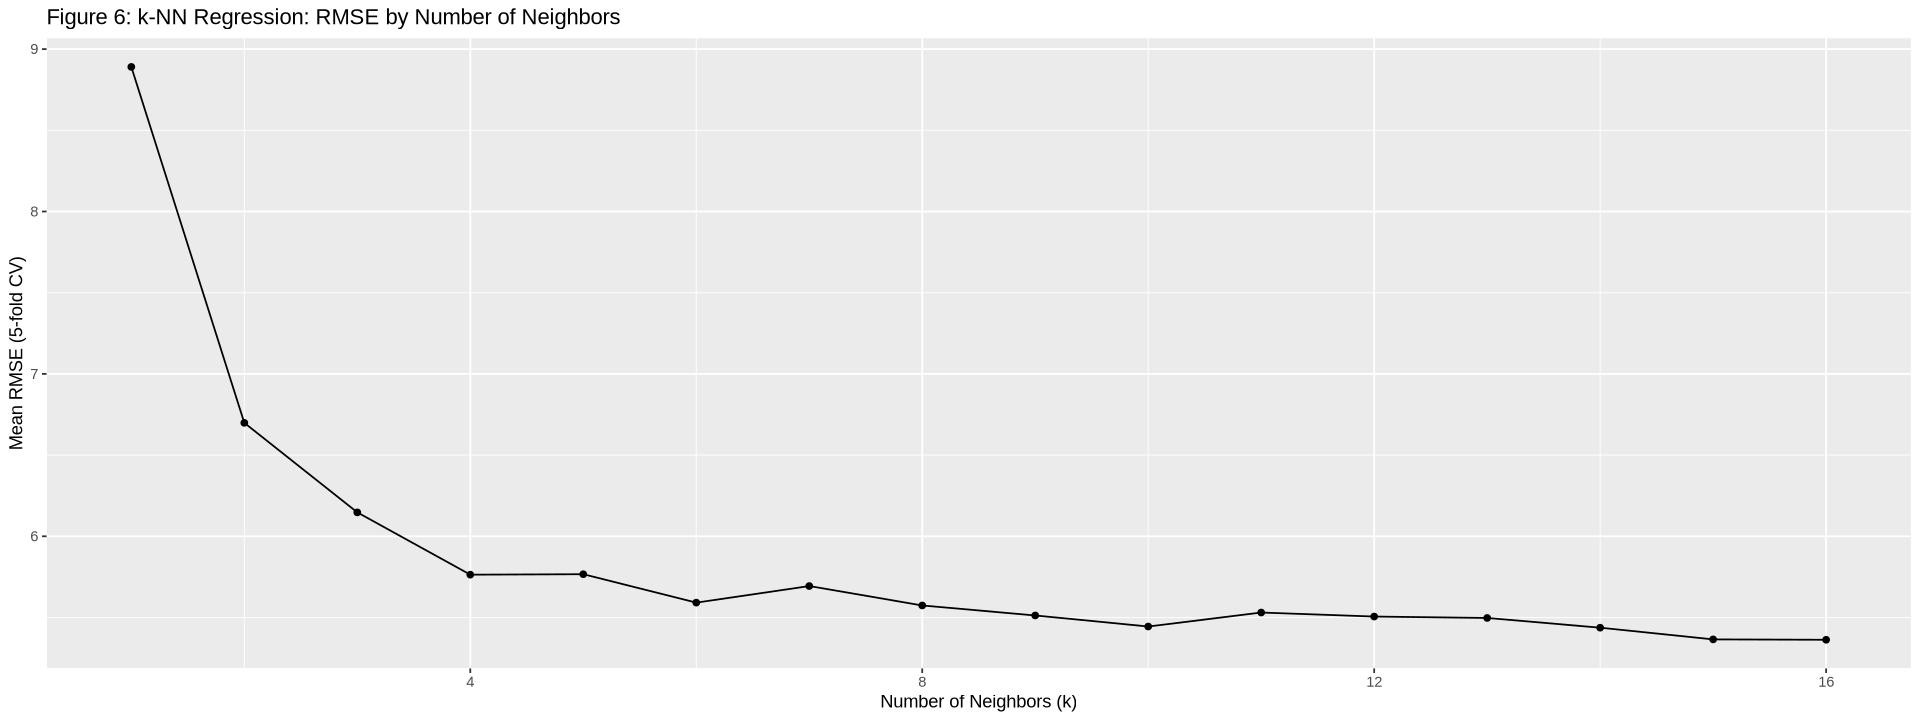

In [84]:
#plot of k neighbors
k_plot <- players_results |>
  filter(.metric == "rmse") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Figure 6: k-NN Regression: RMSE by Number of Neighbors",
    x = "Number of Neighbors (k)",
    y = "Mean RMSE (5-fold CV)")
k_plot

The following code shows the steps in which we now use the optimal k-value we found to predict the players' played hours in the test data using the training data. 

In [85]:
## Predict KNN with K min RSME
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

players_best_fit <- workflow() |>
         add_recipe(players_recipe) |>
         add_model(players_best_spec) |>
         fit(data = players_training)

players_summary <- players_best_fit |>
          predict(players_testing) |>
          bind_cols(players_testing) #|>

players_metrics <- players_summary |>
        metrics(truth = played_hours, estimate = .pred)

head(players_summary)

players_metrics

.pred,Age,experience,subscribe,gender,played_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.58125,21,2,1,2,0.7
3.45000,19,3,1,2,0.0
5.03125,25,1,1,2,1.5
1.27500,17,1,1,1,0.0
0.53125,21,5,1,1,0.1
0.43125,20,5,1,1,0.4


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.80357582
rsq,standard,0.01335776
mae,standard,1.96282328


The analysis leaves us with a table above, which includes the predicted values as well as the column played_hours representing the actual values. We also calculated our RMSE, which is also shown above. 

Next, in the code below, we will be conducting visualizations to help us assess the accuracy of our predicted values compared to the actual values for played hours.

In [86]:
# for visualisation purpose redo factors
players_characters <- players_summary |> 
    mutate(genderc = case_when(
      gender %in% c(1) ~ "Male",
      gender %in% c(2) ~ "Female",
      gender %in% c(3) ~ "Other"))|>

    mutate(experiencec = case_when(
      experience %in% c(1) ~ "Beginner",
      experience %in% c(2) ~ "Amateur",
      experience %in% c(3) ~ "Regular",
      experience %in% c(4) ~ "Pro",
      experience %in% c(5) ~ "Veteran"))|>

    mutate(subscribec = case_when(
      subscribe %in% c(1) ~ "subscribed",
      subscribe %in% c(0) ~ "not subscribed"))

players_characters <- players_characters|>
    mutate(
        Age = as.numeric(Age),
        subscribec = as.factor(subscribec),
        experiencec = as.factor(experiencec),
        genderc = as.factor(genderc))
head(players_characters)

.pred,Age,experience,subscribe,gender,played_hours,genderc,experiencec,subscribec
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
3.58125,21,2,1,2,0.7,Female,Amateur,subscribed
3.45000,19,3,1,2,0.0,Female,Regular,subscribed
5.03125,25,1,1,2,1.5,Female,Beginner,subscribed
1.27500,17,1,1,1,0.0,Male,Beginner,subscribed
0.53125,21,5,1,1,0.1,Male,Veteran,subscribed
0.43125,20,5,1,1,0.4,Male,Veteran,subscribed


In [87]:
## Plot the KNN Results
options(repr.plot.width = 20, repr.plot.height = 10)
players_pred_plot_age <- players_characters |>
      ggplot(aes(x = Age, y = played_hours, color = genderc)) +
      geom_point() +
      geom_line(aes(x = Age, y = .pred), color = "blue") +
      labs(
        title = "Figure 7: Age Predicted vs Actual Played Hours",
        caption = "hello",
        x = "Age",
        y = "Hours Played [Hours]",
        color = "gender")

players_pred_plot_gender <- players_characters |>
      ggplot(aes(x = gender, y = played_hours)) +
      geom_point() +
      geom_line(aes(x = gender, y = .pred), color = "blue") +
      labs(
        title = "Figure 8: Gender Predicted vs Actual Played Hours",
        x = "Gender",
        y = "Hours Played [Hours]")

players_pred_plot_subscribe <- players_characters |>
      ggplot(aes(x = subscribe, y = played_hours, color = experiencec)) +
      geom_point() +
      geom_line(aes(x = subscribe, y = .pred), color = "blue") +
      labs(
        title = "Figure 9: Subscription Status Predicted vs Actual Played Hours",
        x = "Subscription Status",
        y = "Hours Played [Hours]")

players_pred_plot_experience <- players_characters |>
      ggplot(aes(x = experience, y = played_hours)) +
      geom_point() +
      geom_line(aes(x = experience, y = .pred), color = "blue") +
      labs(
        title = "Figure 10: Experience Predicted vs Actual Played Hours",
        x = "Experience",
        y = "Hours Played [Hours]")


!! DESCRIBE HERE THE GRAPH BELOW

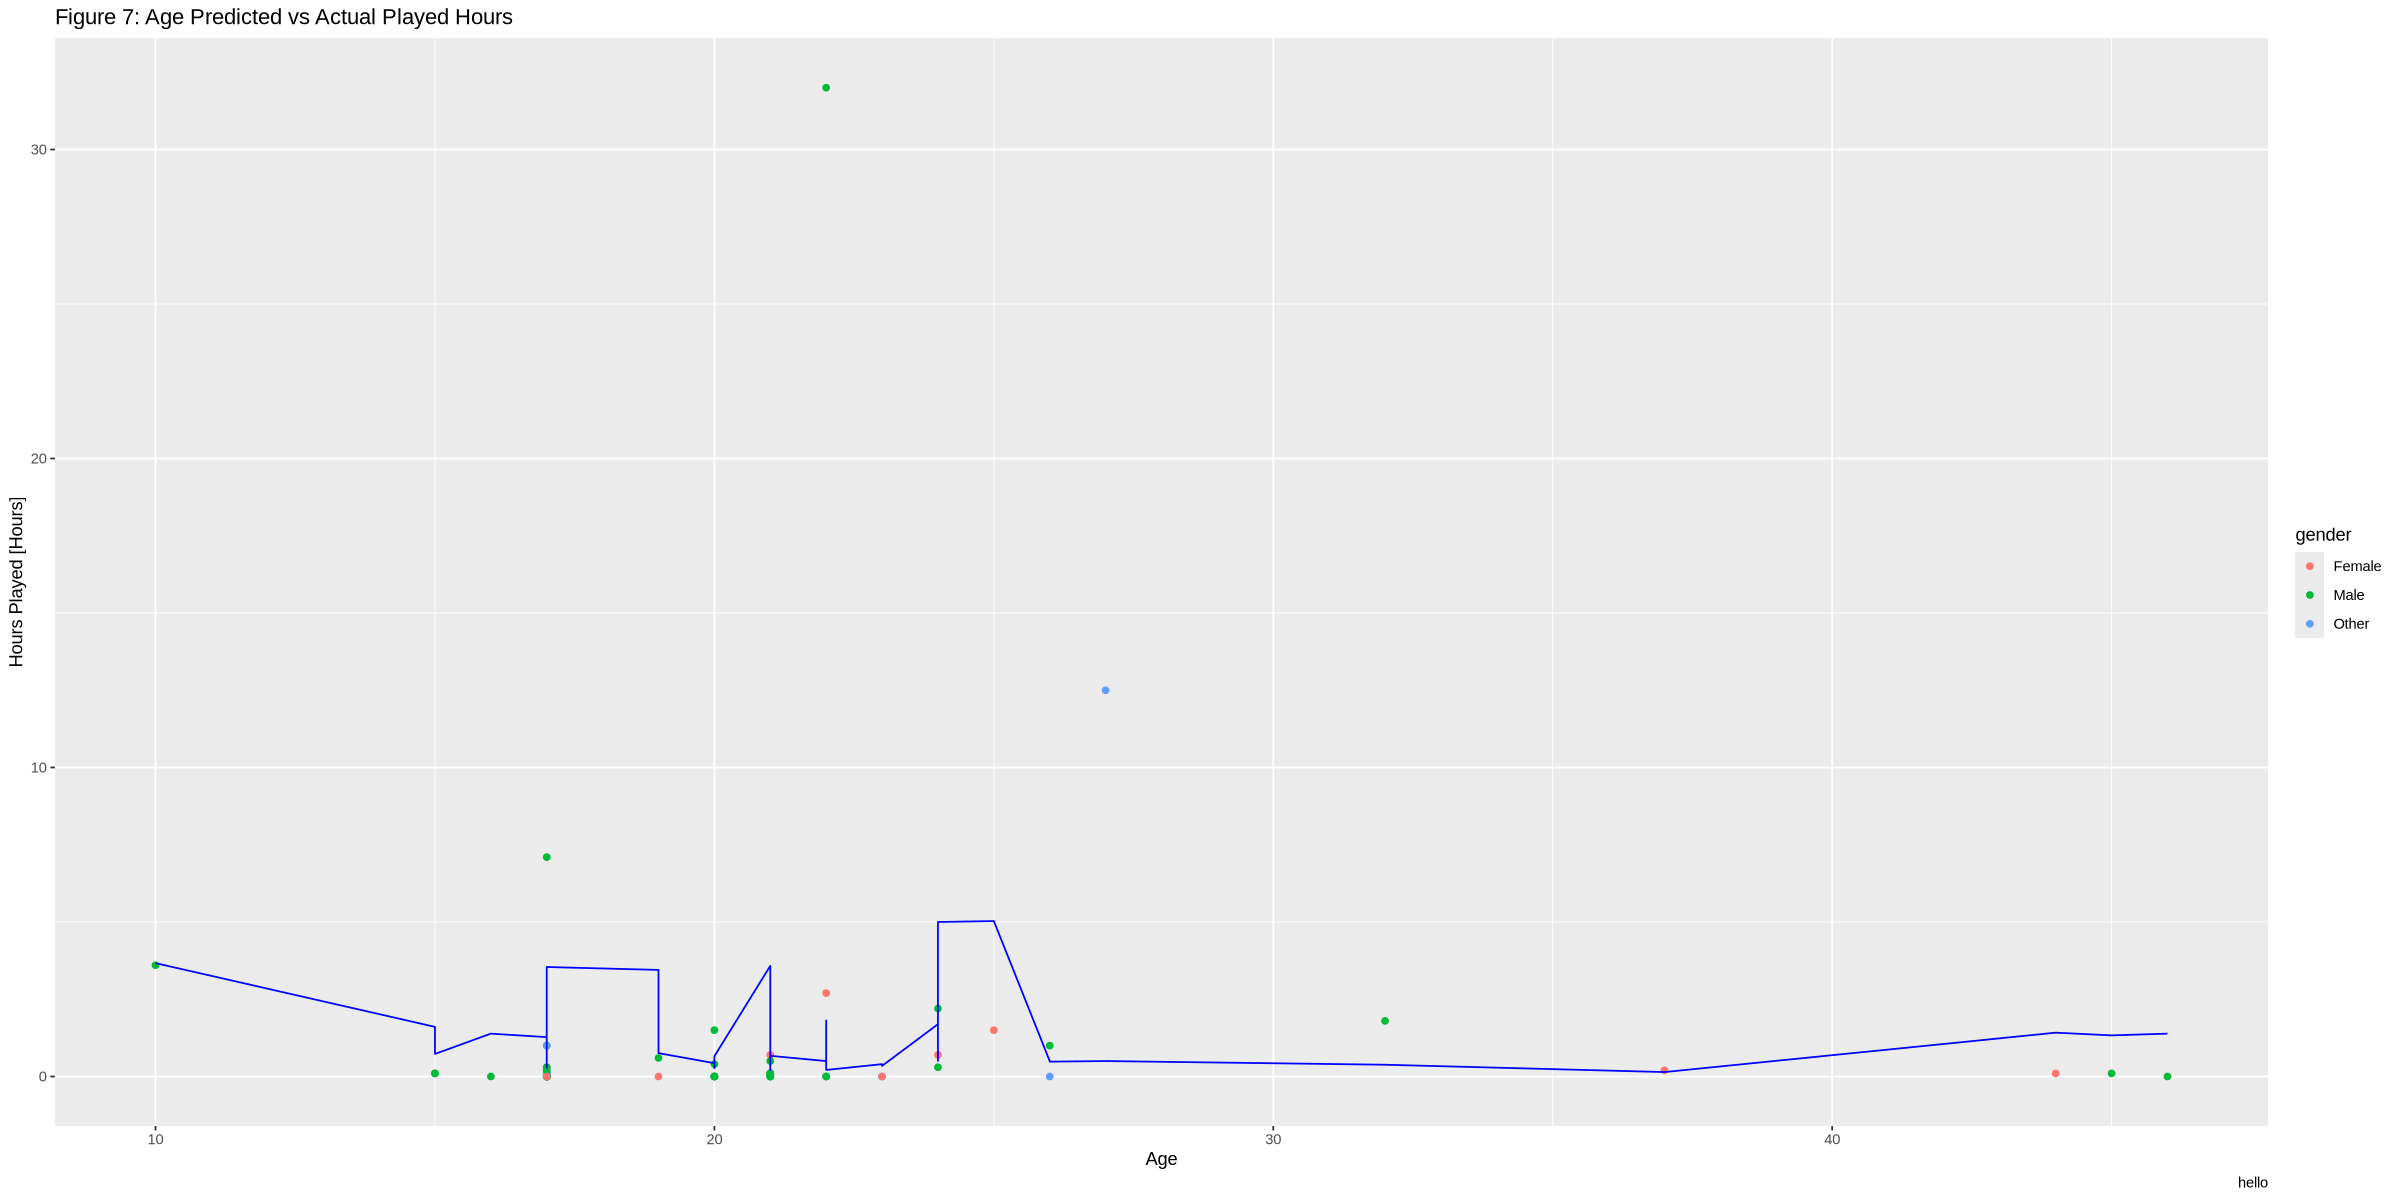

In [34]:
players_pred_plot_age

!! DESCRIBE HERE THE GRAPH BELOW

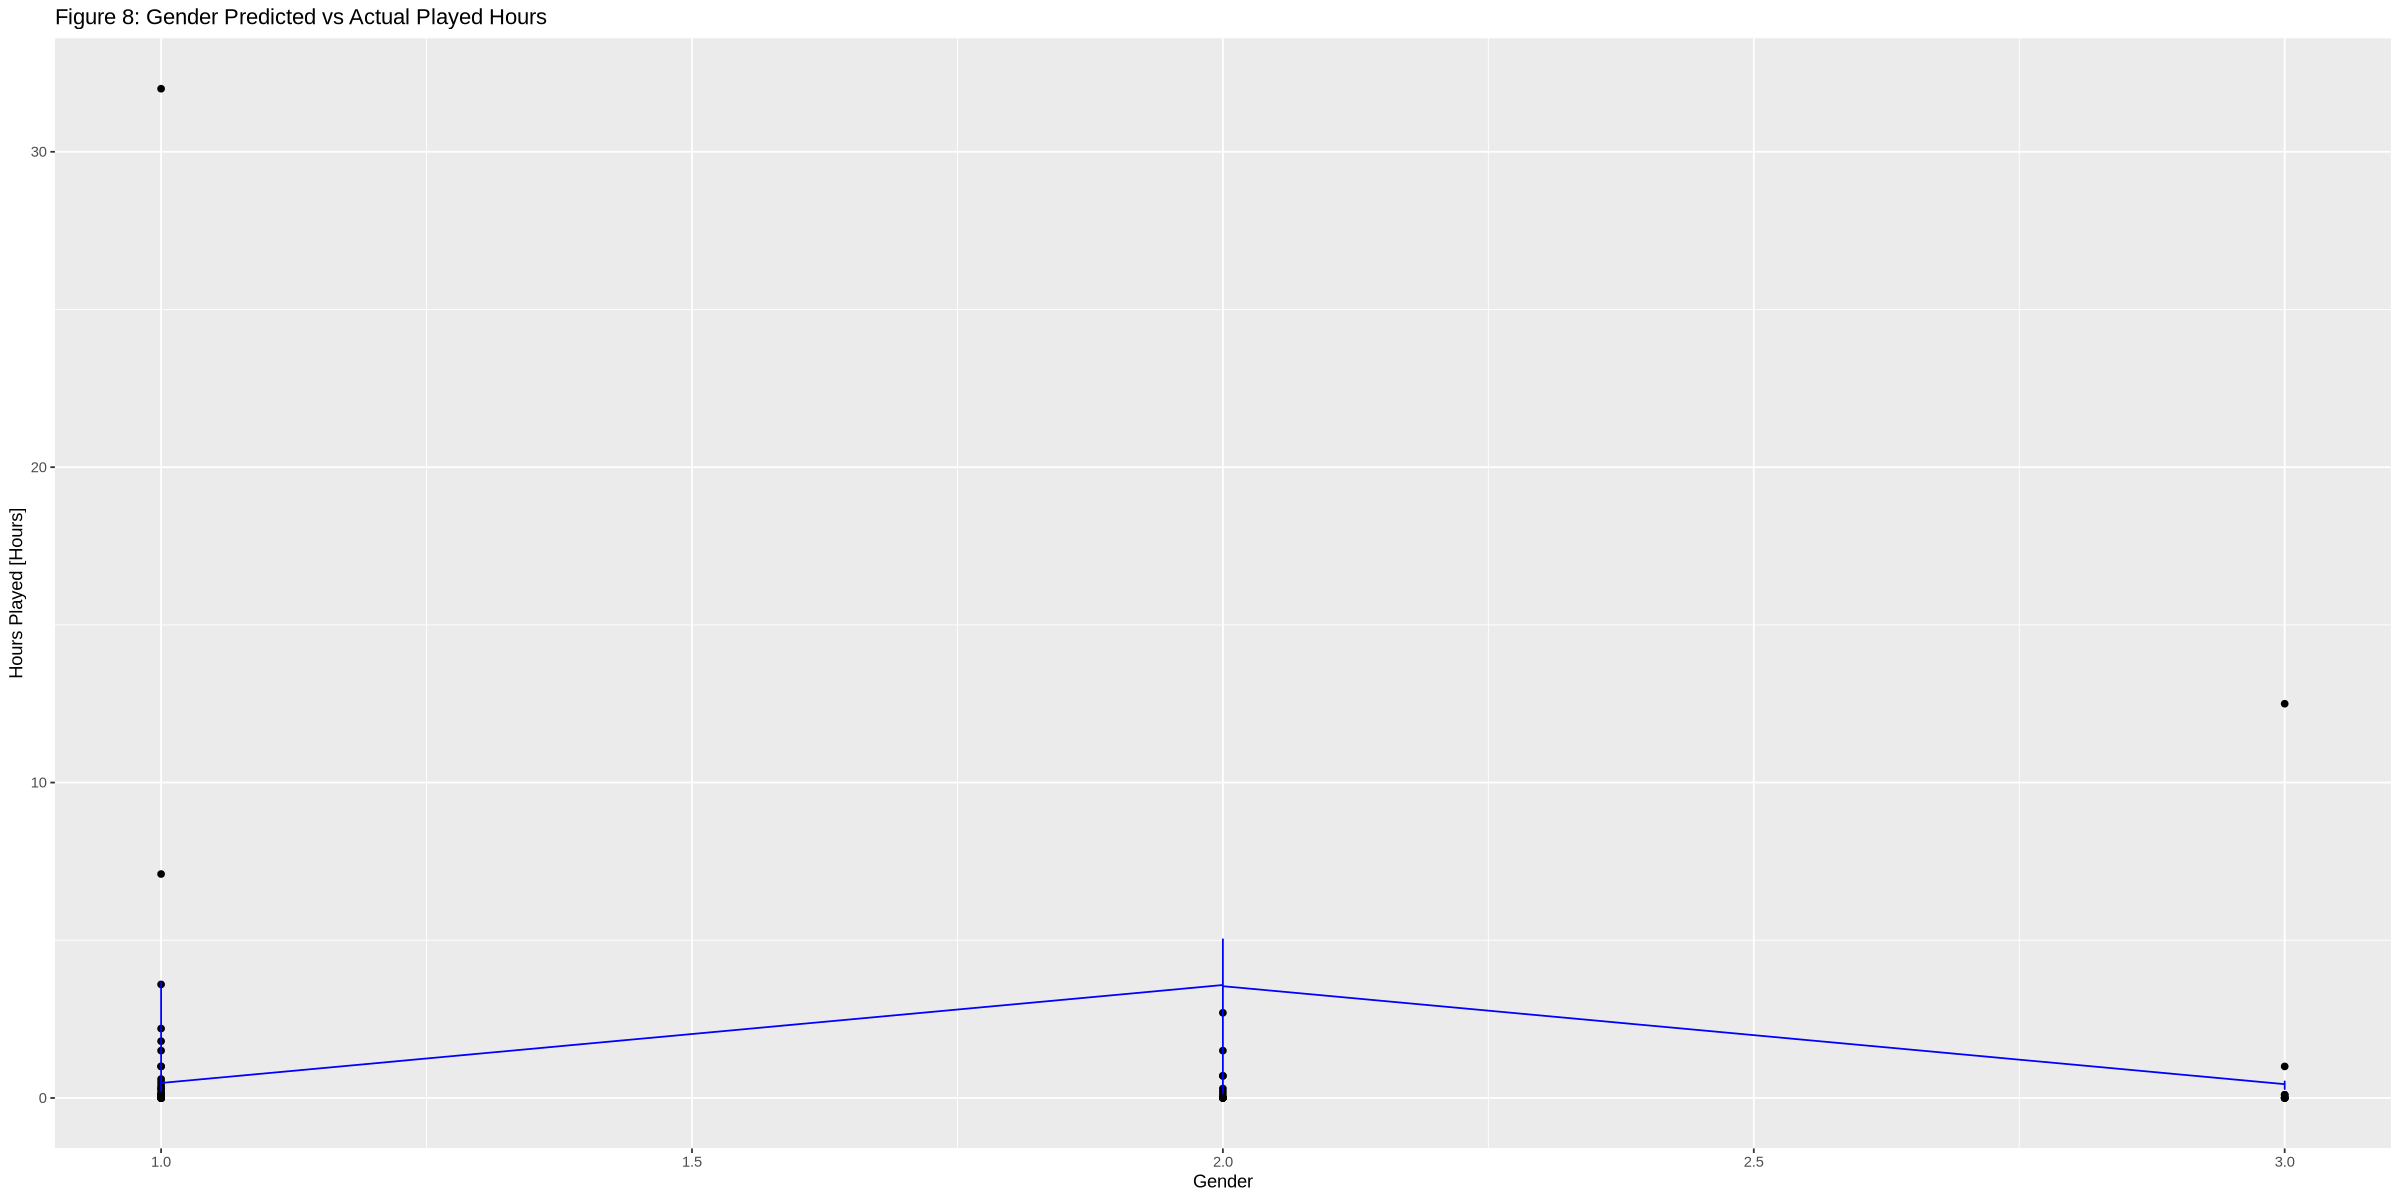

In [28]:
players_pred_plot_gender

!! DESCRIBE HERE THE GRAPH BELOW

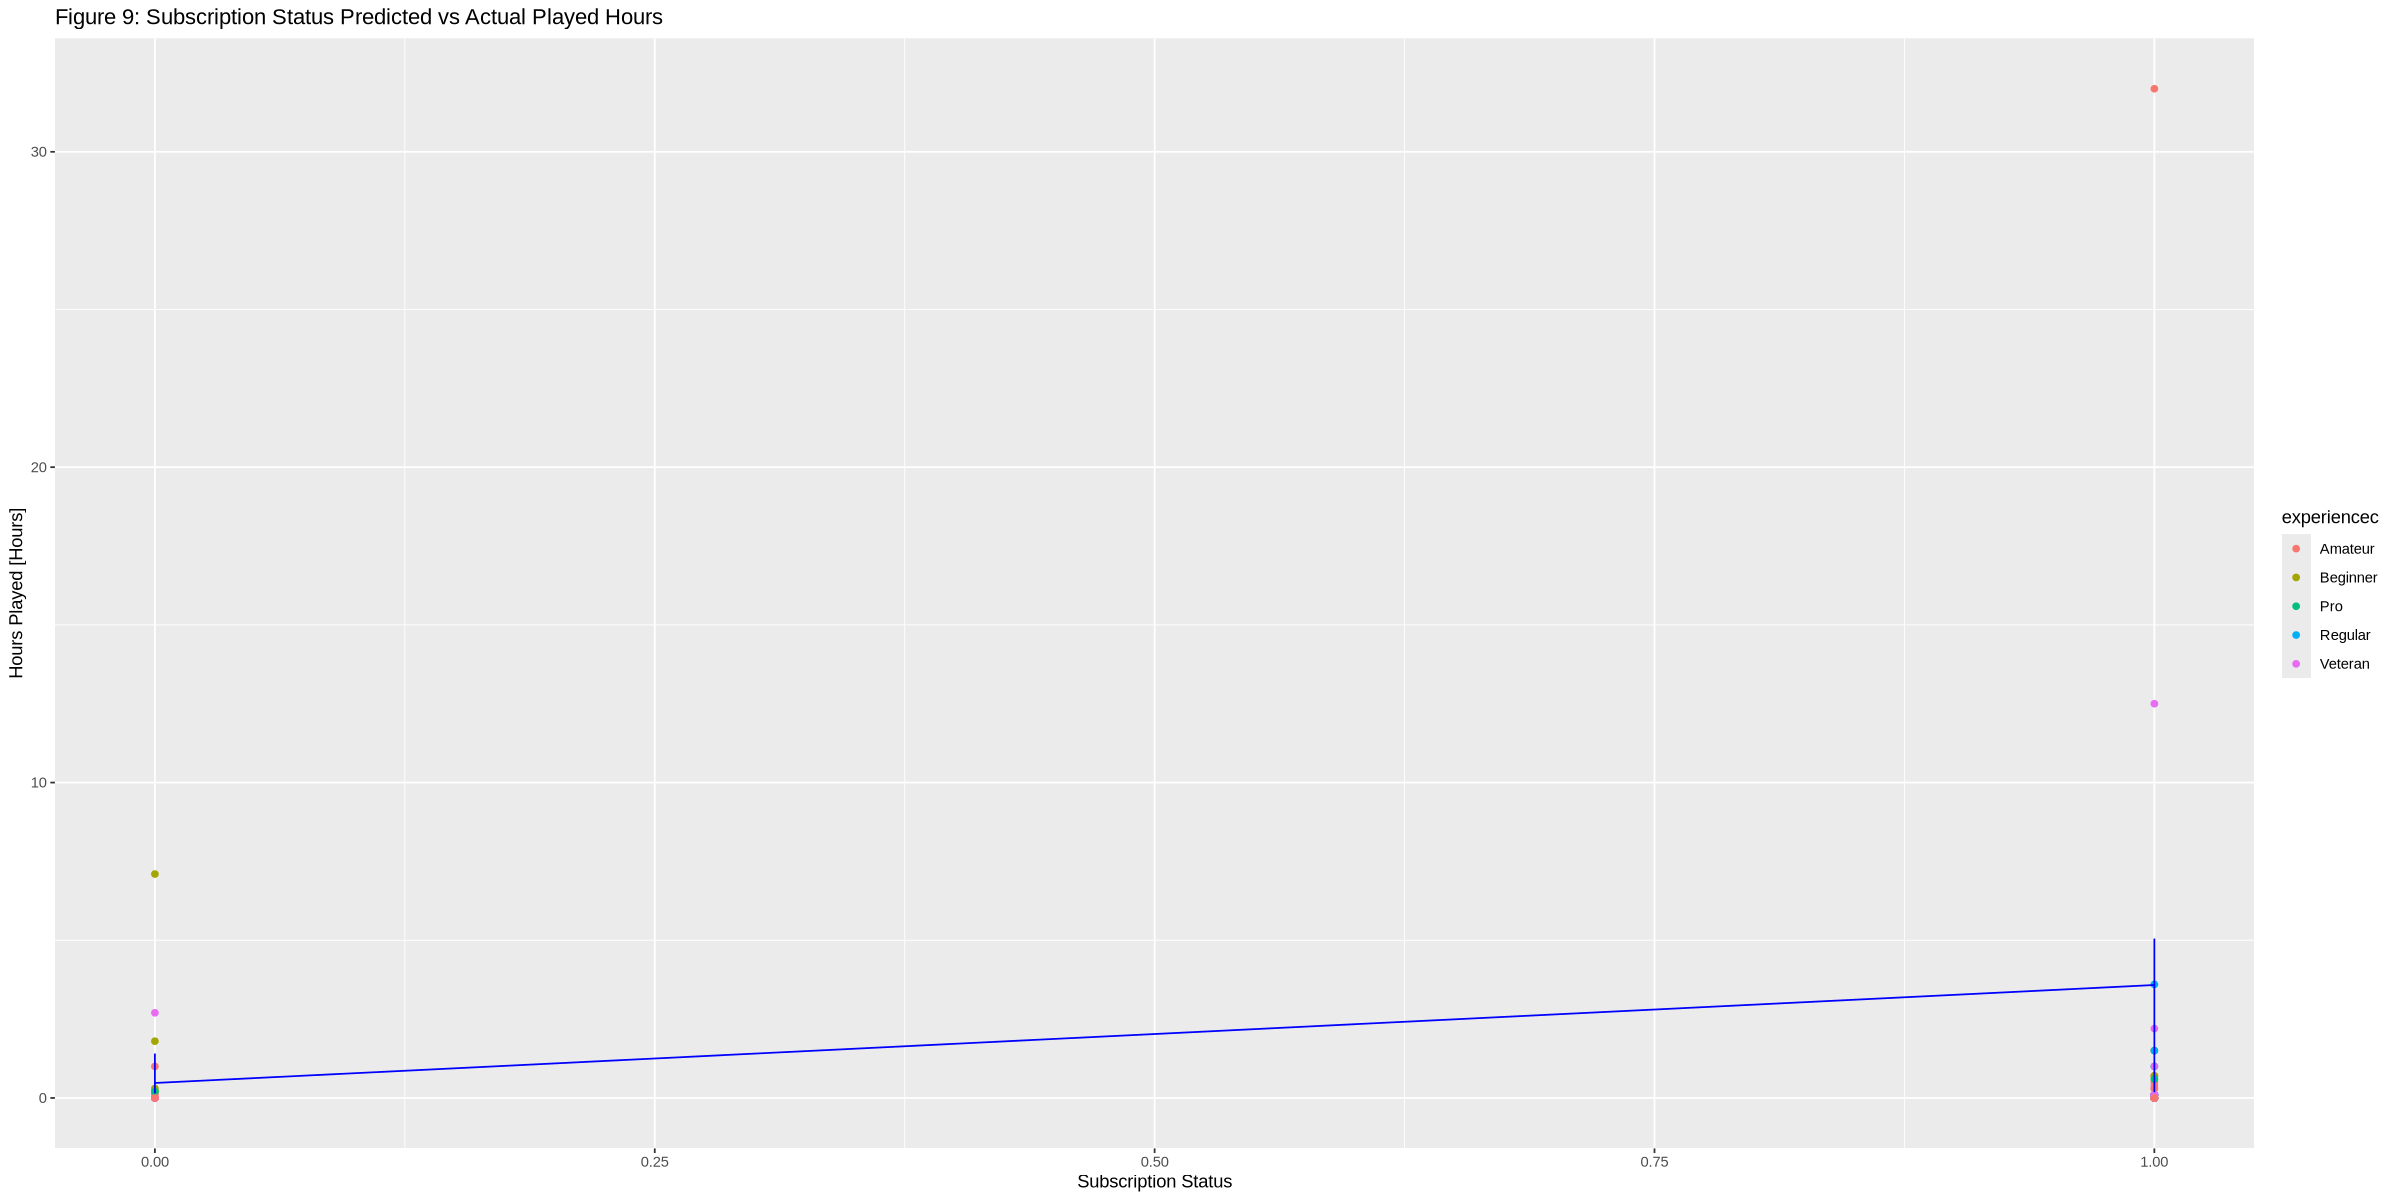

In [30]:
players_pred_plot_subscribe

!! DESCRIBE HERE THE GRAPH BELOW

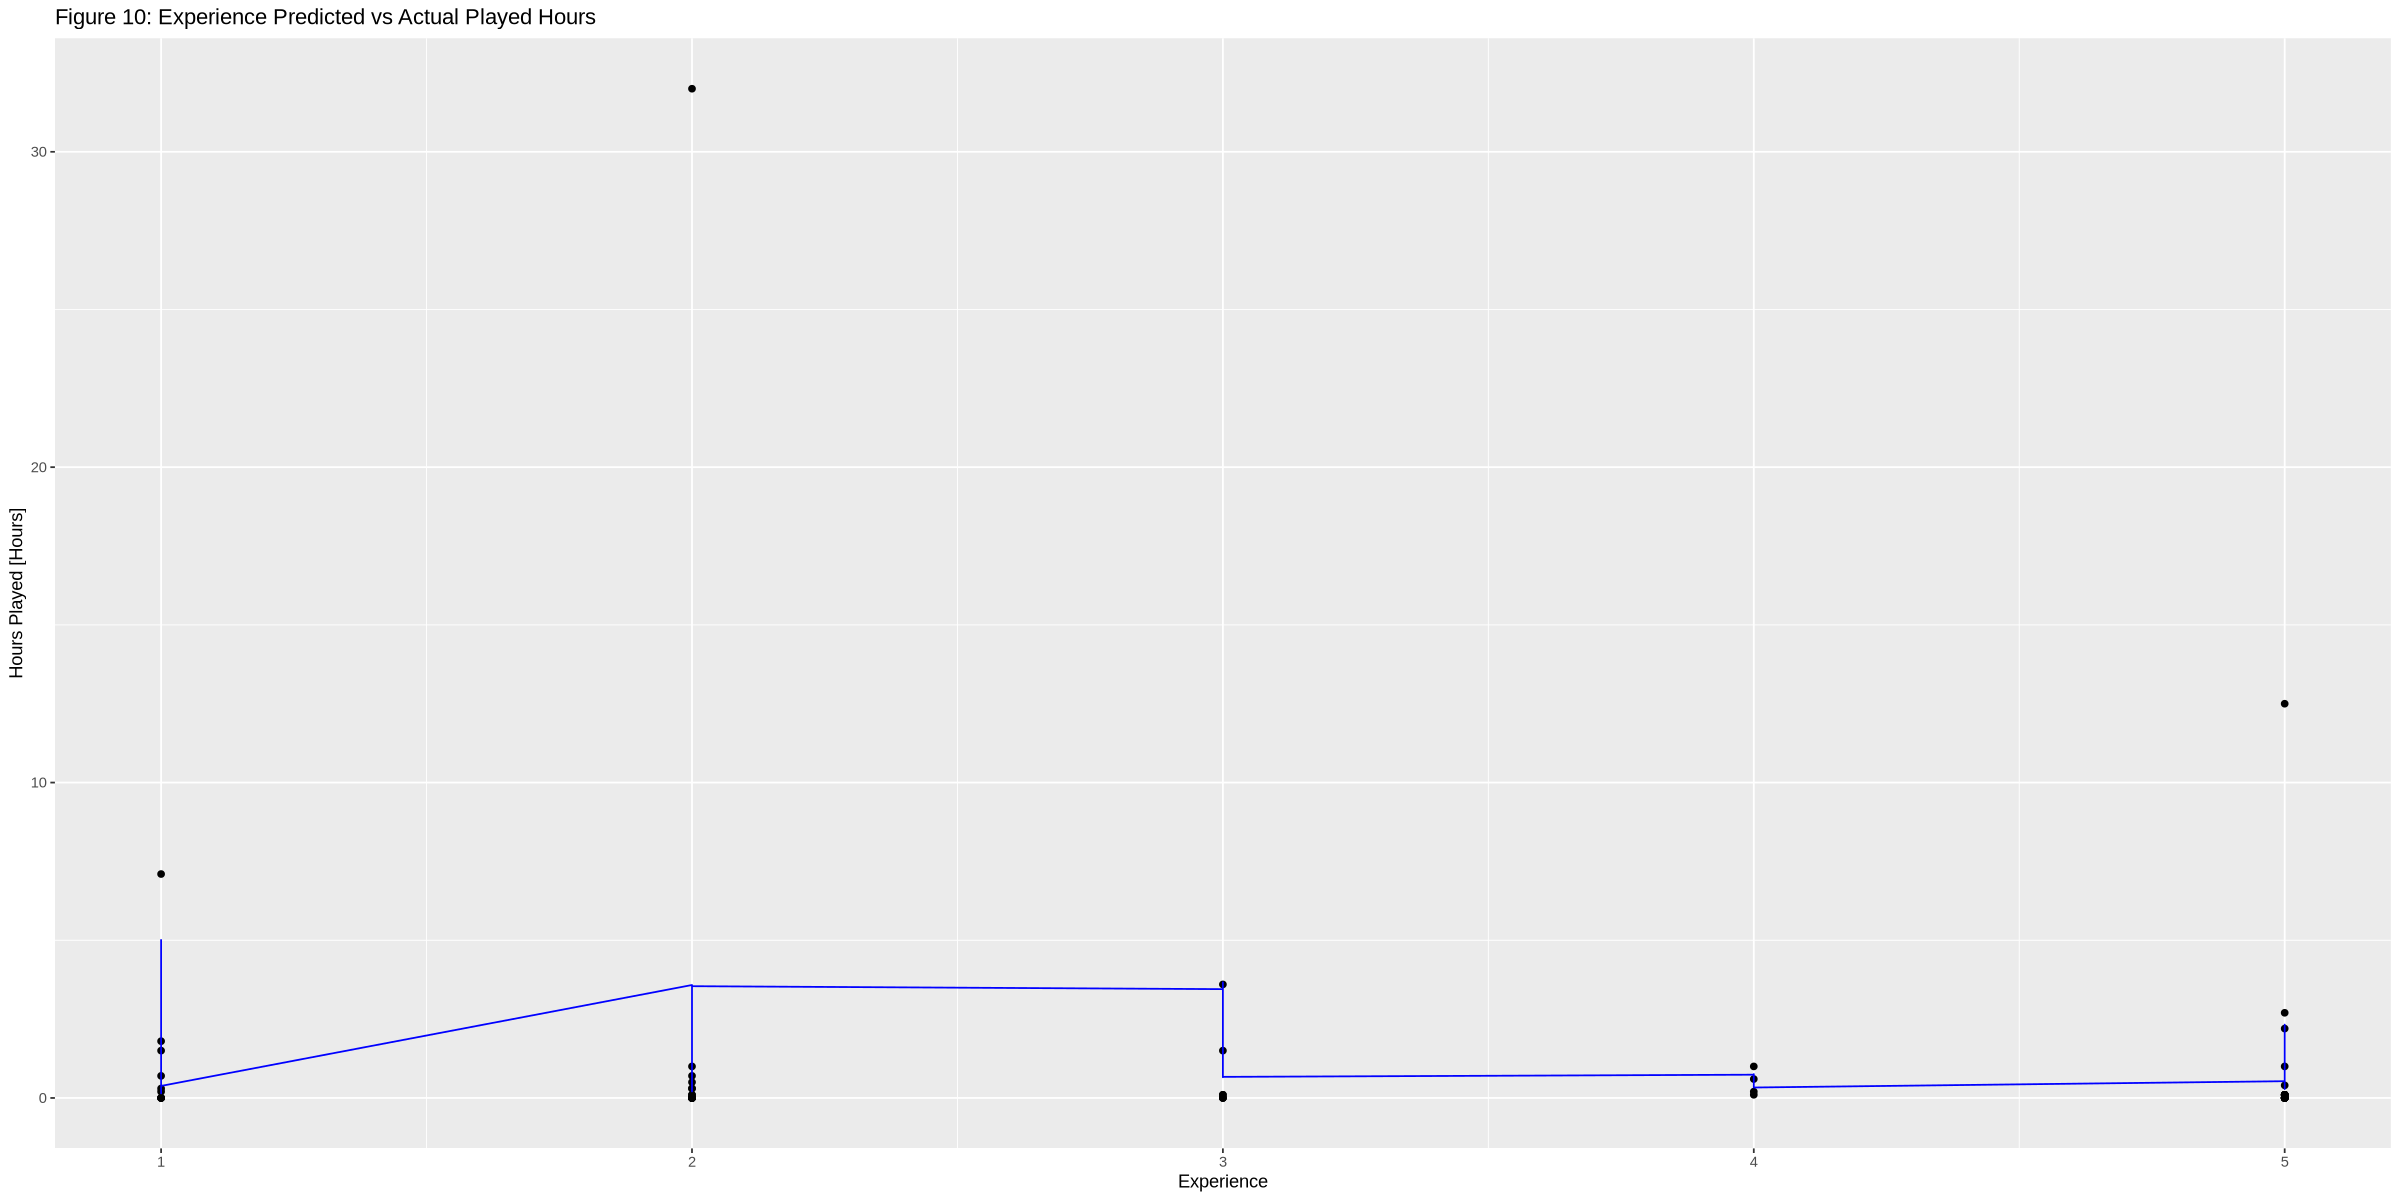

In [32]:
players_pred_plot_experience

# Discussion 
- summarize what you found discuss whether this is what you expected to find discuss what impact could such findings have
- discuss what future questions could this lead to





In summary, the data was divided into a training set and a testing set in order to perform K-NN regression to predict a player’s “played hours” based on their experience level, subscription status, gender, and age. An optimal K-value of 16 is found, and K-NN regression is performed to predict the players’ played hours on the test set using the train set.
The KNN regression model did not perform well when predicting total played hours using age, experience, gender, and subscription status. The RMSE is about 5.14, which is very large considering that most players in the dataset only logged between 0 and 5 hours of playtime. This means the model’s average prediction error is often bigger than the actual values themselves. The visualizations support this: across all four predictors, the predicted lines are nearly flat or show irregular, jumpy patterns, while the actual points remain tightly clustered near zero with a few extreme outliers. This indicates that the predictors do not have strong or consistent relationships with played hours, so KNN has difficulty finding useful neighbors to base its predictions on. Overall, the model suggests that age, experience, gender, and subscription status are weak predictors of how many hours a player actually plays, leading to unstable and inaccurate predictions.




# References: 
You may include references if necessary, as long as they all have a consistent citation style.